# Global BGC metrics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr

from dask.distributed import Client

#import catalog
#import util
import utils
xr.set_options(keep_attrs=True)
from glob import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
import numpy as np
import pandas as pd

In [3]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

/glade/work/kristenk/miniconda/envs/analysis5/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


### Parameters

In [4]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [5]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [6]:
variables =['photoC_sp_zint','photoC_diat_zint',
            'photoC_diaz_zint','photoC_cocco_zint',
            'SiO2_PROD','CaCO3_PROD_zint','diaz_Nfix',
            'mesozooC','microzooC','x_graze_microzoo_zint','x_graze_mesozoo_zint',
            'POC_FLUX_100m']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [7]:
def preprocess(ds):
    ds=ds.mean(dim='time')
    ds=ds.isel(z_t=slice(0,10))
    return ds

### Select 1986 to 2005

In [9]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    ds_var = xr.Dataset()
    print('starting on ', var)
    
    for yr in np.arange(1986,2006,1):
    
        

        files = sorted(glob(f'{path}/{case}.pop.h.{var}.{yr}??-{yr}??.nc'))       
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                           drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)
                                  #chunks={"nlat": 1200, "nlon": 1200, "time": 1, "z_t": 1, "z_t_150m": 1})

        keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
        ds_var = xr.concat([ds_var,ds_tmp],dim='time')
        
    ds_var = ds_var.mean(dim='time')
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_var])

starting on  photoC_sp_zint
starting on  photoC_diat_zint
starting on  photoC_diaz_zint
starting on  photoC_cocco_zint
starting on  SiO2_PROD


/glade/work/kristenk/miniconda/envs/analysis5/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


starting on  CaCO3_PROD_zint


/glade/work/kristenk/miniconda/envs/analysis5/lib/python3.7/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


starting on  diaz_Nfix
starting on  mesozooC
starting on  microzooC
starting on  x_graze_microzoo_zint
starting on  x_graze_mesozoo_zint
starting on  POC_FLUX_100m


In [10]:
ds_fosi_x01

<xarray.Dataset>
Dimensions:                (nlat: 2400, nlon: 3600, z_t: 10, z_t_150m: 15)
Coordinates:
    TLAT                   (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    TLONG                  (nlat, nlon) float64 nan nan nan nan ... nan nan nan
  * z_t                    (z_t) float32 500.0 1.5e+03 ... 8.5e+03 9.5e+03
  * z_t_150m               (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    photoC_sp_zint         (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    dz                     (z_t) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    photoC_diat_zint       (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    photoC_diaz_zint       (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    photoC_cocco_zint      (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SiO2_PROD              (z_t, nlat, nlon) float32 dask.array<chunksize=(10, 2400, 3600), meta=np.ndarray>
    ...                     ...
    diaz_Nfix              (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
    mesozooC               (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
    microzooC              (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 2400, 3600), meta=np.ndarray>
    x_graze_microzoo_zint  (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    x_graze_mesozoo_zint   (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    POC_FLUX_100m          (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>

### Connect to cluster

In [11]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='256GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=256GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [12]:
cluster, client = get_ClusterClient()
cluster.scale(5) 
client

Client Scheduler: tcp://10.12.205.11:39961 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load the data

In [13]:
ds_fosi_x01 = ds_fosi_x01.load()

In [14]:
keep_vars=['z_t','z_t_150m','dz','time_bound','TAREA','TLAT','TLONG'] + variables
ds_fosi_x01 = ds_fosi_x01.drop([v for v in ds_fosi_x01.variables if v not in keep_vars])

In [15]:
ds_fosi_x01

<xarray.Dataset>
Dimensions:                (nlat: 2400, nlon: 3600, z_t: 10, z_t_150m: 15)
Coordinates:
    TLAT                   (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    TLONG                  (nlat, nlon) float64 nan nan nan nan ... nan nan nan
  * z_t                    (z_t) float32 500.0 1.5e+03 ... 8.5e+03 9.5e+03
  * z_t_150m               (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    photoC_sp_zint         (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    dz                     (z_t) float32 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    photoC_diat_zint       (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    photoC_diaz_zint       (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    photoC_cocco_zint      (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    SiO2_PROD              (z_t, nlat, nlon) float32 nan nan nan ... nan nan nan
    ...                     ...
    diaz_Nfix              (z_t_150m, nlat, nlon) float32 nan nan ... nan nan
    mesozooC               (z_t_150m, nlat, nlon) float32 nan nan ... nan nan
    microzooC              (z_t_150m, nlat, nlon) float32 nan nan ... nan nan
    x_graze_microzoo_zint  (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    x_graze_mesozoo_zint   (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    POC_FLUX_100m          (nlat, nlon) float32 nan nan nan nan ... nan nan nan

In [16]:
# dt_wgt = ds_fosi_x01.time_bound.diff('d2').squeeze()
# dt_wgt /= dt_wgt.sum()
# #dt_wgt

In [17]:
#ds_fosi_x01 = ds_fosi_x01.weighted(dt_wgt).mean('time')

In [18]:
ds_fosi_x01

<xarray.Dataset>
Dimensions:                (nlat: 2400, nlon: 3600, z_t: 10, z_t_150m: 15)
Coordinates:
    TLAT                   (nlat, nlon) float64 nan nan nan nan ... nan nan nan
    TLONG                  (nlat, nlon) float64 nan nan nan nan ... nan nan nan
  * z_t                    (z_t) float32 500.0 1.5e+03 ... 8.5e+03 9.5e+03
  * z_t_150m               (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    photoC_sp_zint         (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    dz                     (z_t) float32 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    photoC_diat_zint       (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    photoC_diaz_zint       (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    photoC_cocco_zint      (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    SiO2_PROD              (z_t, nlat, nlon) float32 nan nan nan ... nan nan nan
    ...                     ...
    diaz_Nfix              (z_t_150m, nlat, nlon) float32 nan nan ... nan nan
    mesozooC               (z_t_150m, nlat, nlon) float32 nan nan ... nan nan
    microzooC              (z_t_150m, nlat, nlon) float32 nan nan ... nan nan
    x_graze_microzoo_zint  (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    x_graze_mesozoo_zint   (nlat, nlon) float32 nan nan nan nan ... nan nan nan
    POC_FLUX_100m          (nlat, nlon) float32 nan nan nan nan ... nan nan nan

### total up NPP

In [19]:
ds_fosi_x01['photoC_TOT_zint'] = ds_fosi_x01['photoC_sp_zint'] + ds_fosi_x01['photoC_diat_zint'] + ds_fosi_x01['photoC_diaz_zint'] + ds_fosi_x01['photoC_cocco_zint']

In [20]:
#ds_fosi_x01 = ds_fosi_x01.drop(['time_bound'])

In [21]:
ds_fosi_x01.photoC_TOT_zint

<xarray.DataArray 'photoC_TOT_zint' (nlat: 2400, nlon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Small Phyto C Fixation Vertical Integral
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean

##### Carbon-related variables

In [22]:
cvars = ['photoC_TOT_zint', 'photoC_sp_zint','photoC_diat_zint',
         'photoC_diaz_zint','photoC_cocco_zint', 'POC_FLUX_100m',
         'CaCO3_PROD_zint','x_graze_microzoo_zint','x_graze_mesozoo_zint']

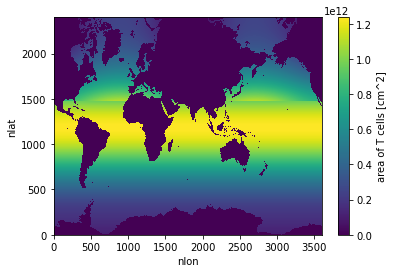

In [23]:
surface_mask = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.) 
surface_mask.plot()

In [24]:
masked_area = {
    v: surface_mask.where(ds_fosi_x01[v].notnull()).fillna(0.) 
    for v in cvars
}
print(masked_area)

{'photoC_TOT_zint': <xarray.DataArray 'TAREA' (nlat: 2400, nlon: 3600)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon
Attributes:
    units:        cm^2
    long_name:    area of T cells
    coordinates:  TLONG TLAT, 'photoC_sp_zint': <xarray.DataArray 'TAREA' (nlat: 2400, nlon: 3600)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan na

In [25]:
ds_glb = xr.Dataset()

for v in cvars:
    print(v)
    print(ds_fosi_x01[v])
    ds_glb[v] = (ds_fosi_x01[v] * masked_area[v]).sum(['nlat', 'nlon'])

photoC_TOT_zint
<xarray.DataArray 'photoC_TOT_zint' (nlat: 2400, nlon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
    TLONG    (nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Small Phyto C Fixation Vertical Integral
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean
photoC_sp_zint
<xarray.DataArray 'photoC_sp_zint' (nlat: 2400, nlon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, n

In [26]:
ds_glb.photoC_cocco_zint.values

array(7.98694434e+15)

In [27]:
cvars = ['photoC_TOT_zint', 'photoC_sp_zint','photoC_diat_zint',
         'photoC_diaz_zint','photoC_cocco_zint', 'POC_FLUX_100m',
         'CaCO3_PROD_zint','x_graze_microzoo_zint','x_graze_mesozoo_zint']

ds_glb = utils.global_mean(ds_fosi_x01, ds_grid, cvars, normalize=False).compute()

nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

for v in cvars:
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

['diaz_Nfix', 'z_t_150m', 'z_t', 'mesozooC', 'TLONG', 'microzooC', 'TLAT', 'SiO2_PROD', 'dz']
going to compute global totals
photoC_TOT_zint
photoC_sp_zint
photoC_diat_zint
photoC_diaz_zint
photoC_cocco_zint
POC_FLUX_100m
CaCO3_PROD_zint
x_graze_microzoo_zint
x_graze_mesozoo_zint


<!-- ##### Zooplankton biomass -->

In [28]:
tmp = (ds_fosi_x01.microzooC * 10.).sum(dim='z_t_150m') #mmol/m2
tmp = (tmp * area_m * 0.001).sum(dim=('nlon','nlat')) ## mol
tmp = tmp.values * 1.e-15 * 12.011 #Pg C
ds_glb['microzooC'] = tmp
ds_glb['microzooC'].attrs['units'] = 'Pg C'

tmp = (ds_fosi_x01.mesozooC * 10.).sum(dim='z_t_150m') #mmol/m2
tmp = (tmp * area_m * 0.001).sum(dim=('nlon','nlat')) ## mol
tmp = tmp.values * 1.e-15 * 12.011 #Pg C
ds_glb['mesozooC'] = tmp
ds_glb['mesozooC'].attrs['units'] = 'Pg C'

##### Percent NPP by diatoms

In [29]:
ds_glb['diatNPPpercent'] = ds_glb.photoC_diat_zint / ds_glb.photoC_TOT_zint * 100.
ds_glb['diatNPPpercent'].attrs['units'] = '%'

##### Diatom silicification

In [30]:
tmp = (ds_fosi_x01.SiO2_PROD.isel(z_t=slice(0,10)) * 10.).sum(dim='z_t') ## depth integral, units in mmol/m2/s
tmp = tmp * area_m ## mmol/s
tmp = tmp * 86400. * 365 * 0.001 ## mol/yr 
tmp = tmp.sum(dim=('nlon','nlat')) * 1.e-12 #Tmol/yr

ds_glb['SiO2_PROD'] = tmp
ds_glb['SiO2_PROD'].attrs['units'] = 'Tmol Si yr$^{-1}$'

##### Nitrogen fixation

In [31]:
tmp = (ds_fosi_x01['diaz_Nfix'] * 10.).sum(dim='z_t_150m') # unit is mmol/m2/s
tmp = tmp * area_m ## mmol/s
tmp = tmp * 86400. * 365. * 0.001 * 14. * 1e-12 #convert to Tg N / yr

ds_glb['diaz_Nfix'] = tmp.sum(dim=('nlon','nlat'))
ds_glb['diaz_Nfix'].attrs['units'] = 'Tg N yr$^{-1}$'

##### Zooplankton productivity as % NPP

In [32]:
ds_glb['zooprodNPPpercent'] = (ds_glb['x_graze_mesozoo_zint'] + ds_glb['x_graze_microzoo_zint'])/ds_glb['photoC_TOT_zint'] * 100.
ds_glb['zooprodNPPpercent'].attrs['units'] = '%'

### Make a table of global metrics

In [33]:
df = pd.DataFrame(columns=['Metric','unit','CESM','Obs','Reference'])

In [34]:
df.loc[0] = ['NPP',ds_glb.photoC_TOT_zint.attrs['units'],np.round(ds_glb.photoC_TOT_zint.values, 2),'45 to 55','Behrenfeld & Falkowski 1997; Carr et al., 2006']
df.loc[1] = ['POC export 100m',ds_glb.POC_FLUX_100m.attrs['units'],np.round(ds_glb.POC_FLUX_100m.values, 2),'4 to 12','DeVries & Weber, 2017']
df.loc[2] = ['%NPP by diatoms',ds_glb.diatNPPpercent.attrs['units'],np.round(ds_glb.diatNPPpercent.values, 2),'40%','Nelson et al., 1995']
df.loc[3] = ['Silicification',ds_glb.SiO2_PROD.attrs['units'],np.round(ds_glb.SiO2_PROD.values, 2),'100 to 190','Nelson et al., 1995; Holzer et al., 2014']
df.loc[4] = ['Calcification',ds_glb.CaCO3_PROD_zint.attrs['units'],np.round(ds_glb.CaCO3_PROD_zint.values, 2),'0.7 to 4.7','Liang et al., 2023; Ziveri et al., 2023 and refs therein']
df.loc[5] = ['Nitrogen fixation',ds_glb.diaz_Nfix.attrs['units'],np.round(ds_glb.diaz_Nfix.values, 2),'125.6 and 222.9','Wang et al., 2019']
df.loc[6] = ['Microzooplankton biomass',ds_glb.microzooC.attrs['units'],np.round(ds_glb.microzooC.values, 2),'0.24','Buitenhuis et al., 2010']
df.loc[7] = ['Mesozooplankton biomass',ds_glb.mesozooC.attrs['units'],np.round(ds_glb.mesozooC.values, 2),'0.16 to 0.19','Buitenhuis et al., 2006; Moriarty & OBrien, 2013']
df.loc[8] = ['Zoo prod % of NPP',ds_glb.zooprodNPPpercent.attrs['units'],np.round(ds_glb.zooprodNPPpercent.values, 2),'at least 21%','Landry and Calbet, 2004']

In [35]:
df

,Metric,unit,CESM,Obs,Reference
0,NPP,Pg C yr$^{-1}$,52.26,45 to 55,"Behrenfeld & Falkowski 1997; Carr et al., 2006"
1,POC export 100m,Pg C yr$^{-1}$,6.39,4 to 12,"DeVries & Weber, 2017"
2,%NPP by diatoms,%,38.17,40%,"Nelson et al., 1995"
3,Silicification,Tmol Si yr$^{-1}$,101.73,100 to 190,"Nelson et al., 1995; Holzer et al., 2014"
4,Calcification,Pg C yr$^{-1}$,0.87,0.7 to 4.7,"Liang et al., 2023; Ziveri et al., 2023 and re..."
5,Nitrogen fixation,Tg N yr$^{-1}$,176.34,125.6 and 222.9,"Wang et al., 2019"
6,Microzooplankton biomass,Pg C,0.24,0.24,"Buitenhuis et al., 2010"
7,Mesozooplankton biomass,Pg C,0.38,0.16 to 0.19,"Buitenhuis et al., 2006; Moriarty & OBrien, 2013"
8,Zoo prod % of NPP,%,25.35,at least 21%,"Landry and Calbet, 2004"


In [36]:
cluster.close()